In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle as pkl
import cv2
import os
import seaborn as sns

from plotly import graph_objects as go
from plotly import express as px
from xml.etree import ElementTree as et
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from collections import Counter
from keras.models import Sequential
from keras.layers.experimental import preprocessing as ps
from keras.layers.experimental import preprocessing as ps
from keras.layers import Activation, Conv2D, BatchNormalization, Dense, Flatten, Dropout, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = []
label2category = {'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}
category2label = {0: 'with_mask', 1: 'without_mask', 2: 'mask_weared_incorrect'}
category2color = {0: (0,255,0), 1: (0,0,255), 2: (0,165,255)}

In [ ]:
for dir, _, files in os.walk('/content/drive/My Drive/Datasets/Face-mask-detection/annotations/'):
    for file_ in files:
        dict_ = dict(img_path=None, objs=[])

        path = os.path.join(dir, file_)
        tree = et.parse(path)
        dict_['img_path'] = os.path.join('/content/drive/My Drive/Datasets/Face-mask-detection/images/', tree.find('filename').text)
        for obj in tree.findall('object'):
            label = obj.find('name').text

            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)

            dict_['objs'].append([xmin, ymin, xmax, ymax, label2category[label]])
        data.append(dict_)

#img_folder = '/content/drive/My Drive/Datasets/Face-mask-detection/images/'
#annot_folder = '/content/drive/My Drive/Datasets/Face-mask-detection/annotations/'

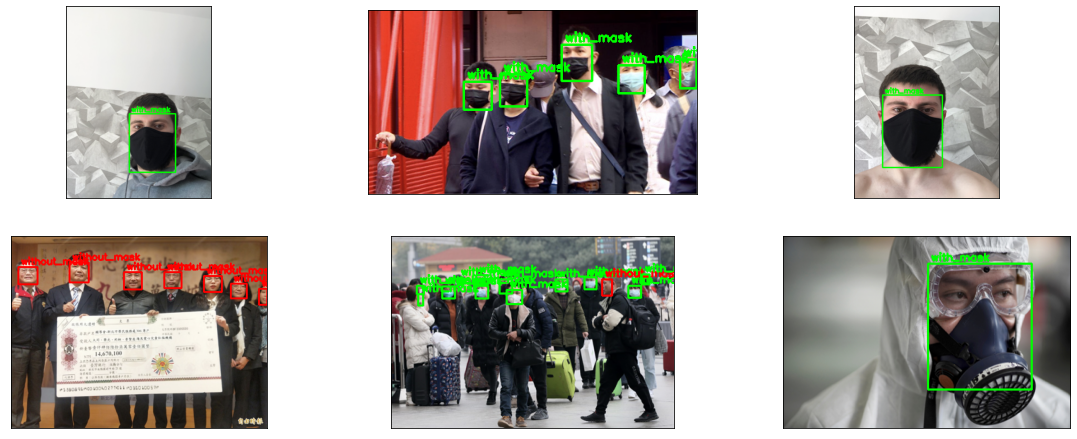

CPU times: user 740 ms, sys: 20.9 ms, total: 760 ms
Wall time: 2.21 s


In [ ]:
%%time

plt.figure(figsize=(20,12))

for i, _data in enumerate(data[22:28]):
    img = cv2.imread(_data['img_path'])
    for (xmin, ymin, xmax, ymax, label) in _data['objs']:
        cv2.rectangle(img , (xmin, ymin), (xmax, ymax), category2color[label], 2)
        cv2.putText(img, str(category2label[label]), (xmin+4, ymin-4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, category2color[label], 2)
    plt.subplot(3,3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()

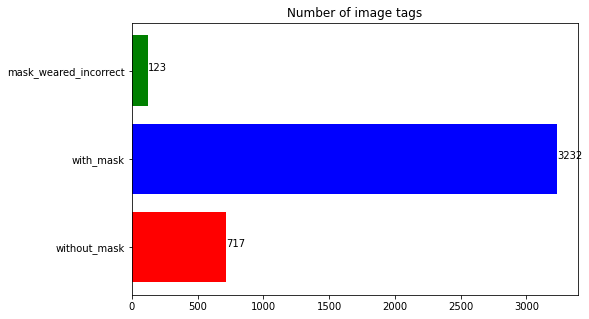

In [ ]:
labels = []
for _data in data:
    for (xmin, ymin, xmax, ymax, label) in _data['objs']:
        label = category2label[label]
        labels.append(label)

labels = np.array(labels)
labels_count = Counter(labels)

plt.figure(figsize=(8,5))
plt.title('Number of image tags')

plt.barh(list(labels_count.keys()), list(labels_count.values()), color=['r', 'b', 'g'])
for i,v in enumerate(labels_count.values()):
    plt.text(v, i, str(v))
plt.show()

In [ ]:
aug_model = Sequential()
aug_model.add(ps.RandomFlip())
aug_model.add(ps.RandomRotation(0.4))

def augment_data(input_img, aument_model, input_label=None, iterate=3):
    img_list = []
    label = []

    label = None
    for _ in range(iterate):
        batch = tf.expand_dims(input_img, 0)
        aug = aug_model(batch)
        img_list.append(np.array(aug[0]))
    return img_list

In [ ]:
%%time

x = []
y = []
IMG_SIZE = (64,64)

for _data in data:

  img_path = _data['img_path']
  for (xmin, ymin, xmax, ymax, label) in _data['objs']:
    img = cv2.imread(img_path)
    crop_img = img[ymin : ymax, xmin : xmax]
    re_img = cv2.resize(crop_img, IMG_SIZE)
    re_img = re_img/255
    target = to_categorical(label, num_classes=3)

    if label == 2:
      aug_img = augment_data(re_img, aug_model, iterate=10)
      for aug in aug_img:
        x.append(np.array(aug)); y.append(target)
    elif label == 1:
        aug_img = augment_data(re_img, aug_model, iterate=3)
        for aug in aug_img:
            x.append(np.array(aug)); y.append(target)
    else:
      x.append(re_img); y.append(target)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

CPU times: user 1min 10s, sys: 3.65 s, total: 1min 14s
Wall time: 4min 19s


In [ ]:
x = np.array(x)
y = np.array(y)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

In [ ]:
print('x_train shape: {}'.format(x_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

x_train shape: (5290, 64, 64, 3)
x_test shape: (1323, 64, 64, 3)
y_train shape: (5290, 3)
y_test shape: (1323, 3)


In [ ]:
def category_convert(data):
    num = []
    for i in range(len(data)):
        num.append(category2label[data[i].argmax()])
    counter = Counter(num)

    return counter

def percent(df):
    _sum = df.sum()
    per = (df/_sum) * 100
    return per

def df_counter(train_counter, test_counter):
    df = pd.DataFrame(columns=['train', 'test'])
    for x in list(train_counter.keys()):
        df.loc[x] = [train_counter[x], test_counter[x]]
    return df


In [ ]:
num_train = category_convert(y_train)
num_test = category_convert(y_test)


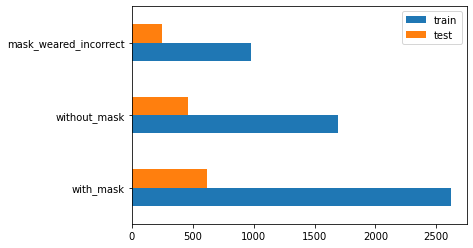

In [ ]:
df = df_counter(num_train, num_test)
df.plot(kind='barh')

In [ ]:
p_train = percent(df['train'])
p_test = percent(df['test'])

print('in train data:\n with mask: {:.2f} %, without mask: {:.2f} %, mask weared incorrect: {:.2f} %'\
      .format(p_train['with_mask'], p_train['without_mask'], p_train['mask_weared_incorrect']))
print('in test data:\n with mask: {:.2f} %, without mask: {:.2f} %, mask weared incorrect: {:.2f} %'\
      .format(p_test['with_mask'], p_test['without_mask'], p_test['mask_weared_incorrect']))

in train data:
 with mask: 49.49 %, without mask: 31.97 %, mask weared incorrect: 18.54 %
in test data:
 with mask: 46.41 %, without mask: 34.77 %, mask weared incorrect: 18.82 %


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape=x_train.shape[1:], activation='relu'))
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), input_shape=x_train.shape[1:], activation='relu'))
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), input_shape=x_train.shape[1:], activation='relu'))
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 128)      

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
CALLBACKS = EarlyStopping(monitor='val_accuracy', patience=10)

In [ ]:
%%time

EPOCHS = 20
BATCH_SIZE = 32

history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, y_test),
    callbacks=[CALLBACKS]
)

Epoch 1/20
166/166 [==============================] - 394s 2s/step - loss: 0.2856 - accuracy: 0.8924 - val_loss: 0.2278 - val_accuracy: 0.9259
Epoch 2/20
166/166 [==============================] - 393s 2s/step - loss: 0.2180 - accuracy: 0.9208 - val_loss: 0.2228 - val_accuracy: 0.9191
Epoch 3/20
166/166 [==============================] - 393s 2s/step - loss: 0.2145 - accuracy: 0.9159 - val_loss: 0.1812 - val_accuracy: 0.9199
Epoch 4/20
166/166 [==============================] - 393s 2s/step - loss: 0.2028 - accuracy: 0.9181 - val_loss: 0.1765 - val_accuracy: 0.9358
Epoch 5/20
166/166 [==============================] - 395s 2s/step - loss: 0.1629 - accuracy: 0.9321 - val_loss: 0.1738 - val_accuracy: 0.9327
Epoch 6/20
166/166 [==============================] - 394s 2s/step - loss: 0.1560 - accuracy: 0.9369 - val_loss: 0.1866 - val_accuracy: 0.9320
Epoch 7/20
166/166 [==============================] - 390s 2s/step - loss: 0.1923 - accuracy: 0.9244 - val_loss: 0.1555 - val_accuracy: 0.9403

In [ ]:
model.evaluate(x_test, y_test)

42/42 [==============================] - 19s 446ms/step - loss: 0.1997 - accuracy: 0.9327


[0.19972236454486847, 0.93272864818573]

In [ ]:
yhat = np.argmax(model.predict(x_test), axis=1)
y = np.argmax(y_test, axis=1)

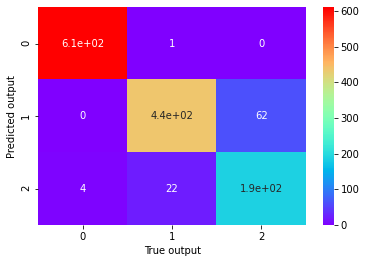

In [ ]:
sns.heatmap(confusion_matrix(yhat, y), annot=True, cmap='rainbow')
plt.ylabel('Predicted output')
plt.xlabel('True output')
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
l = history.history['loss']
val_l = history.history['val_loss']
epoch_len = range(1,len(l)+1)

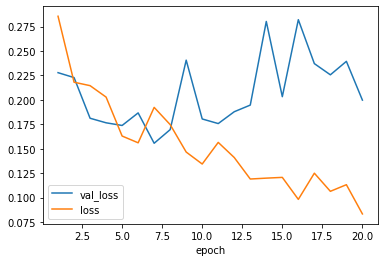

In [ ]:
plt.plot(epoch_len, val_l, label='val_loss')
plt.plot(epoch_len, l, label='loss')
plt.xlabel('epoch')
plt.ylabel('')
plt.legend()
plt.show()

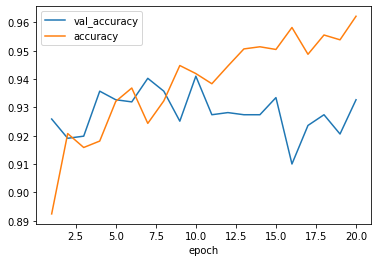

In [ ]:
plt.plot(epoch_len, val_acc, label='val_accuracy')
plt.plot(epoch_len, acc, label='accuracy')
plt.xlabel('epoch')
plt.ylabel('')
plt.legend()
plt.show()

In [ ]:
model.save('Mask_detection_AI')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Mask_detection_AI/assets


In [ ]:
yhat = np.argmax(model.predict(x_test), axis=1)


In [ ]:
yhat

array([1, 0, 1, ..., 2, 0, 0])